In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import random
import math

In [4]:
MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'

In [5]:
fixedImg = np.load(MRI_Path.format('0701'))

In [7]:
transformedImg = np.zeros(fixedImg.shape)

translation = np.eye(4)
rotX = np.eye(4)
rotY = np.eye(4)
rotZ = np.eye(4)
scaling = np.eye(4)

xTranslationRange = 3
yTranslationRange = 10
zTranslationRange = 10
translation[0, 3] = xTranslationRange * random.random()
translation[1, 3] = yTranslationRange * random.random()
translation[2, 3] = zTranslationRange * random.random()

xRotAngle = math.pi / random.uniform(20, 200)
rotX[1, 1] = math.cos(xRotAngle)
rotX[1, 2] = math.sin(xRotAngle)
rotX[2, 1] = -math.sin(xRotAngle)
rotX[2, 2] = math.cos(xRotAngle)

yRotAngle = math.pi / random.uniform(350, 500)
rotY[0, 0] = math.cos(yRotAngle)
rotY[0, 2] = -math.sin(yRotAngle)
rotY[2, 0] = math.sin(yRotAngle)
rotY[2, 2] = math.cos(yRotAngle)

zRotAngle = math.pi / random.uniform(350, 500)
rotZ[0, 0] = math.cos(zRotAngle)
rotZ[0, 1] = -math.sin(zRotAngle)
rotZ[1, 0] = math.sin(zRotAngle)
rotZ[1, 1] = math.cos(zRotAngle)

scalingX = random.uniform(0.95, 1.05)
scalingY = random.uniform(0.9, 1.1)
scalingZ = random.uniform(0.9, 1.1)
scaling[0, 0] = scalingX
scaling[1, 1] = scalingY
scaling[2, 2] = scalingZ

transMat = translation @ rotZ @ rotY @ rotX @ scaling

out = scipy.ndimage.affine_transform(input=fixedImg, matrix=np.linalg.inv(transMat), output=transformedImg)
print(transMat)
print(transMat[0:3].flatten())

[[ 0.95911967 -0.008492   -0.0082258   0.67540462]
 [ 0.00839279  0.99996454  0.02807246  7.79597024]
 [ 0.00820711 -0.03017522  0.93259701  0.30419806]
 [ 0.          0.          0.          1.        ]]
[ 0.95911967 -0.008492   -0.0082258   0.67540462  0.00839279  0.99996454
  0.02807246  7.79597024  0.00820711 -0.03017522  0.93259701  0.30419806]


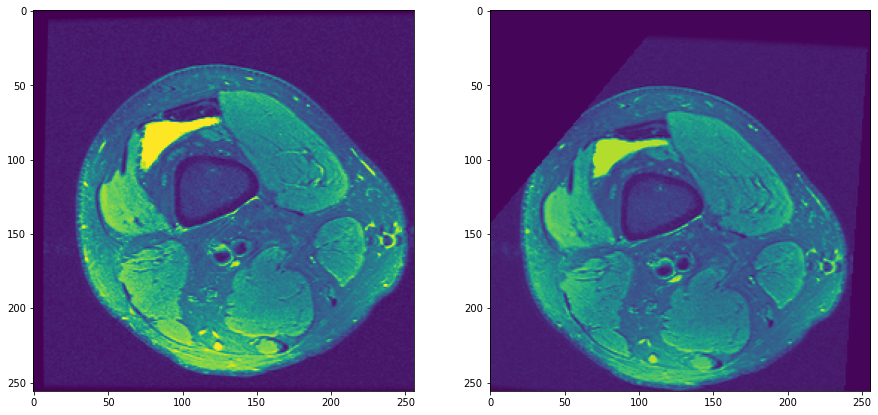

In [245]:
sliceToCheck = 2
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(fixedImg[sliceToCheck, :, :])
axs[1].imshow(transformedImg[sliceToCheck, :, :])

In [247]:
for i in range(2000):
    transformedImg = np.zeros(fixedImg.shape)

    translation = np.eye(4)
    rotX = np.eye(4)
    rotY = np.eye(4)
    rotZ = np.eye(4)
    scaling = np.eye(4)

    xTranslationRange = 3
    yTranslationRange = 10
    zTranslationRange = 10
    translation[0, 3] = xTranslationRange * random.random()
    translation[1, 3] = yTranslationRange * random.random()
    translation[2, 3] = zTranslationRange * random.random()

    xRotAngle = math.pi / random.uniform(20, 200)
    rotX[1, 1] = math.cos(xRotAngle)
    rotX[1, 2] = math.sin(xRotAngle)
    rotX[2, 1] = -math.sin(xRotAngle)
    rotX[2, 2] = math.cos(xRotAngle)

    yRotAngle = math.pi / random.uniform(350, 500)
    rotY[0, 0] = math.cos(yRotAngle)
    rotY[0, 2] = -math.sin(yRotAngle)
    rotY[2, 0] = math.sin(yRotAngle)
    rotY[2, 2] = math.cos(yRotAngle)

    zRotAngle = math.pi / random.uniform(350, 500)
    rotZ[0, 0] = math.cos(zRotAngle)
    rotZ[0, 1] = -math.sin(zRotAngle)
    rotZ[1, 0] = math.sin(zRotAngle)
    rotZ[1, 1] = math.cos(zRotAngle)

    scalingX = random.uniform(0.95, 1.05)
    scalingY = random.uniform(0.9, 1.1)
    scalingZ = random.uniform(0.9, 1.1)
    scaling[0, 0] = scalingX
    scaling[1, 1] = scalingY
    scaling[2, 2] = scalingZ

    transMat = translation @ rotZ @ rotY @ rotX @ scaling

    out = scipy.ndimage.affine_transform(input=fixedImg, matrix=np.linalg.inv(transMat), output=transformedImg)
    
    path = "./affineTrainingData/affine{}.npz"
    f = open(path.format(i), "wb")
    reshapedLabel = transMat[0:3].flatten()
    np.savez(f, img = transformedImg, trf = reshapedLabel)
    f.close()
    print("file {} has been saved.".format(i))

file 0 has been saved.
file 1 has been saved.
file 2 has been saved.
file 3 has been saved.
file 4 has been saved.
file 5 has been saved.
file 6 has been saved.
file 7 has been saved.
file 8 has been saved.
file 9 has been saved.
file 10 has been saved.
file 11 has been saved.
file 12 has been saved.
file 13 has been saved.
file 14 has been saved.
file 15 has been saved.
file 16 has been saved.
file 17 has been saved.
file 18 has been saved.
file 19 has been saved.
file 20 has been saved.
file 21 has been saved.
file 22 has been saved.
file 23 has been saved.
file 24 has been saved.
file 25 has been saved.
file 26 has been saved.
file 27 has been saved.
file 28 has been saved.
file 29 has been saved.
file 30 has been saved.
file 31 has been saved.
file 32 has been saved.
file 33 has been saved.
file 34 has been saved.
file 35 has been saved.
file 36 has been saved.
file 37 has been saved.
file 38 has been saved.
file 39 has been saved.
file 40 has been saved.
file 41 has been saved.
fi

file 333 has been saved.
file 334 has been saved.
file 335 has been saved.
file 336 has been saved.
file 337 has been saved.
file 338 has been saved.
file 339 has been saved.
file 340 has been saved.
file 341 has been saved.
file 342 has been saved.
file 343 has been saved.
file 344 has been saved.
file 345 has been saved.
file 346 has been saved.
file 347 has been saved.
file 348 has been saved.
file 349 has been saved.
file 350 has been saved.
file 351 has been saved.
file 352 has been saved.
file 353 has been saved.
file 354 has been saved.
file 355 has been saved.
file 356 has been saved.
file 357 has been saved.
file 358 has been saved.
file 359 has been saved.
file 360 has been saved.
file 361 has been saved.
file 362 has been saved.
file 363 has been saved.
file 364 has been saved.
file 365 has been saved.
file 366 has been saved.
file 367 has been saved.
file 368 has been saved.
file 369 has been saved.
file 370 has been saved.
file 371 has been saved.
file 372 has been saved.


file 661 has been saved.
file 662 has been saved.
file 663 has been saved.
file 664 has been saved.
file 665 has been saved.
file 666 has been saved.
file 667 has been saved.
file 668 has been saved.
file 669 has been saved.
file 670 has been saved.
file 671 has been saved.
file 672 has been saved.
file 673 has been saved.
file 674 has been saved.
file 675 has been saved.
file 676 has been saved.
file 677 has been saved.
file 678 has been saved.
file 679 has been saved.
file 680 has been saved.
file 681 has been saved.
file 682 has been saved.
file 683 has been saved.
file 684 has been saved.
file 685 has been saved.
file 686 has been saved.
file 687 has been saved.
file 688 has been saved.
file 689 has been saved.
file 690 has been saved.
file 691 has been saved.
file 692 has been saved.
file 693 has been saved.
file 694 has been saved.
file 695 has been saved.
file 696 has been saved.
file 697 has been saved.
file 698 has been saved.
file 699 has been saved.
file 700 has been saved.


file 989 has been saved.
file 990 has been saved.
file 991 has been saved.
file 992 has been saved.
file 993 has been saved.
file 994 has been saved.
file 995 has been saved.
file 996 has been saved.
file 997 has been saved.
file 998 has been saved.
file 999 has been saved.
file 1000 has been saved.
file 1001 has been saved.
file 1002 has been saved.
file 1003 has been saved.
file 1004 has been saved.
file 1005 has been saved.
file 1006 has been saved.
file 1007 has been saved.
file 1008 has been saved.
file 1009 has been saved.
file 1010 has been saved.
file 1011 has been saved.
file 1012 has been saved.
file 1013 has been saved.
file 1014 has been saved.
file 1015 has been saved.
file 1016 has been saved.
file 1017 has been saved.
file 1018 has been saved.
file 1019 has been saved.
file 1020 has been saved.
file 1021 has been saved.
file 1022 has been saved.
file 1023 has been saved.
file 1024 has been saved.
file 1025 has been saved.
file 1026 has been saved.
file 1027 has been save

file 1305 has been saved.
file 1306 has been saved.
file 1307 has been saved.
file 1308 has been saved.
file 1309 has been saved.
file 1310 has been saved.
file 1311 has been saved.
file 1312 has been saved.
file 1313 has been saved.
file 1314 has been saved.
file 1315 has been saved.
file 1316 has been saved.
file 1317 has been saved.
file 1318 has been saved.
file 1319 has been saved.
file 1320 has been saved.
file 1321 has been saved.
file 1322 has been saved.
file 1323 has been saved.
file 1324 has been saved.
file 1325 has been saved.
file 1326 has been saved.
file 1327 has been saved.
file 1328 has been saved.
file 1329 has been saved.
file 1330 has been saved.
file 1331 has been saved.
file 1332 has been saved.
file 1333 has been saved.
file 1334 has been saved.
file 1335 has been saved.
file 1336 has been saved.
file 1337 has been saved.
file 1338 has been saved.
file 1339 has been saved.
file 1340 has been saved.
file 1341 has been saved.
file 1342 has been saved.
file 1343 ha

file 1621 has been saved.
file 1622 has been saved.
file 1623 has been saved.
file 1624 has been saved.
file 1625 has been saved.
file 1626 has been saved.
file 1627 has been saved.
file 1628 has been saved.
file 1629 has been saved.
file 1630 has been saved.
file 1631 has been saved.
file 1632 has been saved.
file 1633 has been saved.
file 1634 has been saved.
file 1635 has been saved.
file 1636 has been saved.
file 1637 has been saved.
file 1638 has been saved.
file 1639 has been saved.
file 1640 has been saved.
file 1641 has been saved.
file 1642 has been saved.
file 1643 has been saved.
file 1644 has been saved.
file 1645 has been saved.
file 1646 has been saved.
file 1647 has been saved.
file 1648 has been saved.
file 1649 has been saved.
file 1650 has been saved.
file 1651 has been saved.
file 1652 has been saved.
file 1653 has been saved.
file 1654 has been saved.
file 1655 has been saved.
file 1656 has been saved.
file 1657 has been saved.
file 1658 has been saved.
file 1659 ha

file 1937 has been saved.
file 1938 has been saved.
file 1939 has been saved.
file 1940 has been saved.
file 1941 has been saved.
file 1942 has been saved.
file 1943 has been saved.
file 1944 has been saved.
file 1945 has been saved.
file 1946 has been saved.
file 1947 has been saved.
file 1948 has been saved.
file 1949 has been saved.
file 1950 has been saved.
file 1951 has been saved.
file 1952 has been saved.
file 1953 has been saved.
file 1954 has been saved.
file 1955 has been saved.
file 1956 has been saved.
file 1957 has been saved.
file 1958 has been saved.
file 1959 has been saved.
file 1960 has been saved.
file 1961 has been saved.
file 1962 has been saved.
file 1963 has been saved.
file 1964 has been saved.
file 1965 has been saved.
file 1966 has been saved.
file 1967 has been saved.
file 1968 has been saved.
file 1969 has been saved.
file 1970 has been saved.
file 1971 has been saved.
file 1972 has been saved.
file 1973 has been saved.
file 1974 has been saved.
file 1975 ha